In [20]:
import yfinance as yf

# Define the ticker symbol
symbol = "GOOG"

# Create a Ticker object for the symbol
ticker = yf.Ticker(symbol)

# Get the available options expirations
expirations = ticker.options

# Get the options chain for the expiration date
options_chain = ticker.option_chain()

# Get the call options and their prices for different strikes
calls = options_chain.calls
call_strikes = calls.strike
call_prices = calls.lastPrice

# Get the put options and their prices for different strikes
puts = options_chain.puts
put_strikes = puts.strike
put_prices = puts.lastPrice

In [25]:
info = ticker.get_info()
refprice = info['open']

In [35]:
from scipy.stats import norm
import numpy as np

def black_scholes(S, K, T, r, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


def df_bs(row):
    S = row['underlying_price']
    K = row['strike']
    T = row['yte']
    r = 0.01 # risk-free interest rate
    sigma = row['implied_volatility']

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if row['option_type'] == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif row['option_type'] == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return price

<Axes: xlabel='strike'>

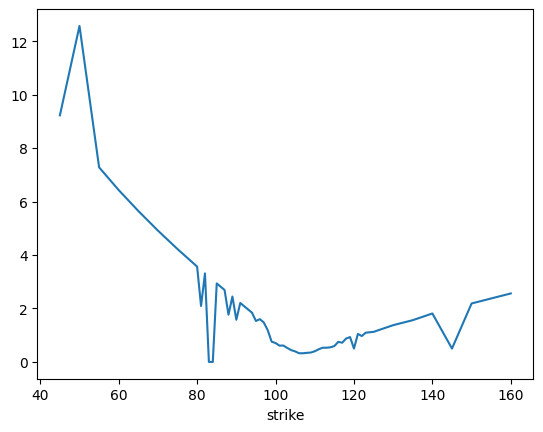

In [33]:
bound = 0.2
mask = (calls.strike > refprice * (1 - bound)) | (calls.strike < refprice * (1 + bound))
filtered_calls = calls[mask].set_index("strike")
filtered_calls['impliedVolatility'].plot()

In [39]:
import datetime
calls['underlying_price'] = refprice
calls['yte'] = np.busday_count(datetime.date.today().date(), calls['lastTradeDate']) / 252.0

AttributeError: module 'datetime' has no attribute 'today'